# Задание 1. RNN, LSTM и GRU

max 20 баллов

Используя код из лекции, попробуйте обучить RNN с размерностью скрытого состояния `hidden_size=2` на следующих периодичных данных и визуализируйте результат.

In [2]:
# Надо дописать датасет и даталоадер

import math

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn

import random
import torch


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

In [3]:
input_size = 1
hidden_size = 2

Функция для визуализации на базе метериала из лекции:

In [4]:
def display(data, pred=None, vert=None, title="Prediction"):
    data = np.array(data).reshape((len(data), 1))
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Some periodic function")
    if pred != None:
        plt.plot(pred, label=title)
    if vert != None:
        plt.axvline(x=vert, c="r", linestyle="--")
    plt.legend()
    plt.grid()
    plt.show()

Генерация данных для обучения:

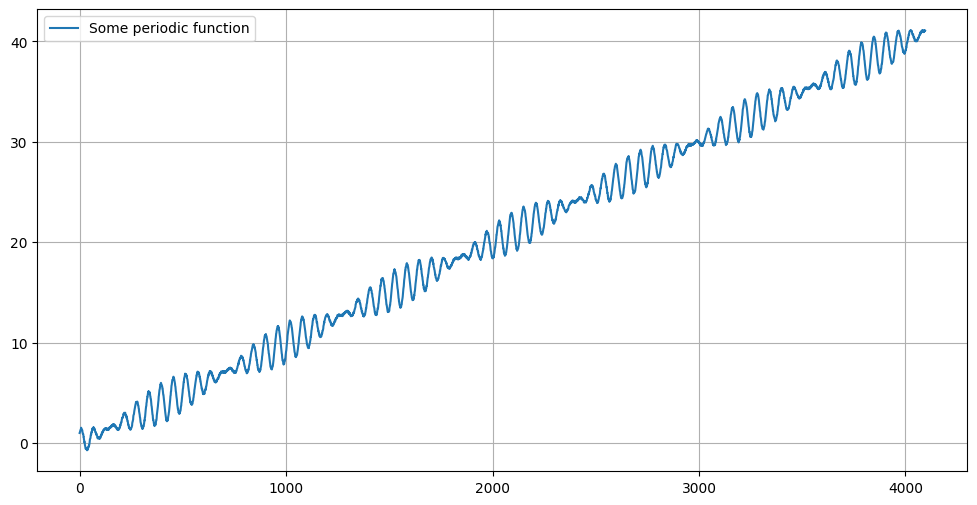

In [169]:
training_data = []
for i in range(4096):
    training_data.append(
        math.sin(i / 10) + math.cos((i) / 9) + i / 100 + (random.random() - 0.5) / 5
    )

display(training_data)

**Подготовка данных**

Данные имеют ярко выраженный линейный тренд  
"A time series with a trend is called non-stationary." 
https://machinelearningmastery.com/time-series-trends-in-python/

удалим его используя функцию [detrend](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) из scipy.signal



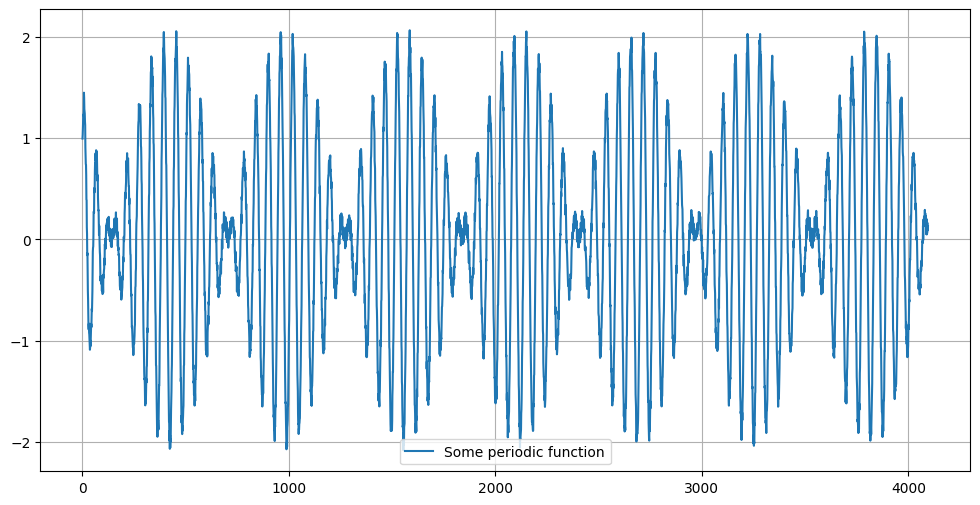

In [170]:
from scipy.signal import detrend

stationary_data = detrend(training_data)
display(stationary_data)

Сохраним тренд что бы иметь возможность восстановить данные:

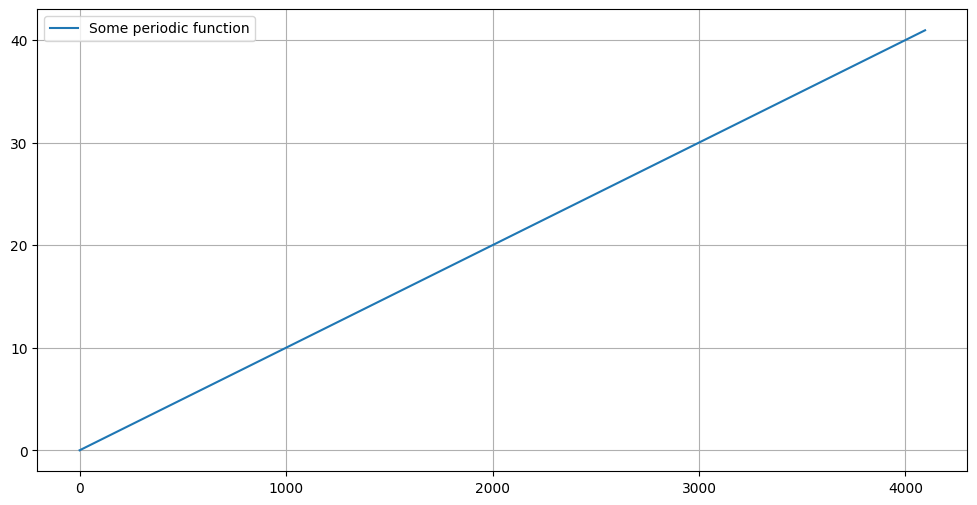

In [171]:
trend = training_data - stationary_data
display(trend)

Теперь следовало бы стандартизовать данные. Но для наших данных среднее равно нулю а дисперсия почти единица, так что этот шаг можено опустить.

In [172]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(stationary_data.reshape(-1, 1))
print(f"Var: {scaler.var_[0]:.2f} Mean {scaler.mean_[0]:.2f}")

Var: 0.98 Mean -0.00


Обучите на этих данных модель с простым RNN слоем и визуализируйте результат.

In [173]:
sd_min = stationary_data.min()
sd_max = stationary_data.max()

In [174]:
stationary_data_tr = (stationary_data - sd_min) / (sd_max - sd_min)

print("\nResulting statistics:")
print("Minimum value:", repr(stationary_data_tr.min()).rjust(5))
print("Maximum value:", repr(stationary_data_tr.max()).rjust(5))


Resulting statistics:
Minimum value:   0.0
Maximum value:   1.0


In [175]:
train_size = int(len(stationary_data_tr) * 0.8)
# test_size = len(stationary_data_tr) - train_size
# train, test = stationary_data_tr[:train_size], stationary_data_tr[train_size:]

In [37]:
# import torch
 
# def create_dataset(dataset, lookback):
   
#     X, y = [], []
#     for i in range(len(dataset)-lookback):
#         feature = dataset[i:i+lookback]
#         target = dataset[i+1:i+lookback+1]
#         X.append(feature)
#         y.append(target)
#     return torch.tensor(X), torch.tensor(y)

In [176]:
import numpy as np
import torch


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i : (i + seq_length)] 
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))


# lookback = 8
# X_train, y_train = create_dataset(train, lookback=lookback)
# X_test, y_test = create_dataset(test, lookback=lookback)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [177]:
seq_length = 8  # compare 2 and 32
x, y = sliding_windows(stationary_data_tr, seq_length)
print("Example of the obtained data:\n")
print("Data corresponding to the first x:")
print(x[0])
print("Data corresponding to the first y:")
print(y[0])

Example of the obtained data:

Data corresponding to the first x:
tensor([0.7422, 0.7510, 0.7674, 0.7770, 0.7993, 0.7967, 0.8094, 0.8514])
Data corresponding to the first y:
tensor(0.8388)


In [178]:
train_size = int(len(y) * 0.8)

x_train = x[:train_size]
y_train = y[:train_size]

x_test = x[train_size:]
y_test = y[train_size:]

x_train.unsqueeze_(2)
y_train.unsqueeze_(1)

x_test.unsqueeze_(2)
y_test.unsqueeze_(1)

print("Train data:")
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)

print("\nTest data:")
print("x shape:", x_test.shape)
print("y shape:", y_test.shape)

Train data:
x shape: torch.Size([3270, 8, 1])
y shape: torch.Size([3270, 1])

Test data:
x shape: torch.Size([818, 8, 1])
y shape: torch.Size([818, 1])


In [91]:

import torch.nn as nn

class Predictor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1) 

    def forward(self, x):
        out, h = self.rnn(x)
        out = self.fc(h)
        return out

In [92]:
def time_series_train(model, num_epochs=2000, learning_rate=0.01):
    criterion = torch.nn.MSELoss()  # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        y_pred = model(x_train)  # we don't use h there, but we can!
        optimizer.zero_grad()

        # obtain the loss
        loss = criterion(y_pred[0], y_train)  # for shape compatibility
        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))


print("Simple RNN training process with MSE loss:")
input_size = 1
hidden_size = 2
rnn = Predictor(input_size, hidden_size)
time_series_train(rnn)

Simple RNN training process with MSE loss:
Epoch: 0,       loss: 0.04757
Epoch: 100,     loss: 0.00050
Epoch: 200,     loss: 0.00046
Epoch: 300,     loss: 0.00043
Epoch: 400,     loss: 0.00041
Epoch: 500,     loss: 0.00040
Epoch: 600,     loss: 0.00039
Epoch: 700,     loss: 0.00039
Epoch: 800,     loss: 0.00038
Epoch: 900,     loss: 0.00038
Epoch: 1000,    loss: 0.00038
Epoch: 1100,    loss: 0.00038
Epoch: 1200,    loss: 0.00039
Epoch: 1300,    loss: 0.00037
Epoch: 1400,    loss: 0.00037
Epoch: 1500,    loss: 0.00037
Epoch: 1600,    loss: 0.00037
Epoch: 1700,    loss: 0.00038
Epoch: 1800,    loss: 0.00037
Epoch: 1900,    loss: 0.00037


In [93]:
x.unsqueeze_(2)
x.shape

torch.Size([4088, 8, 1])

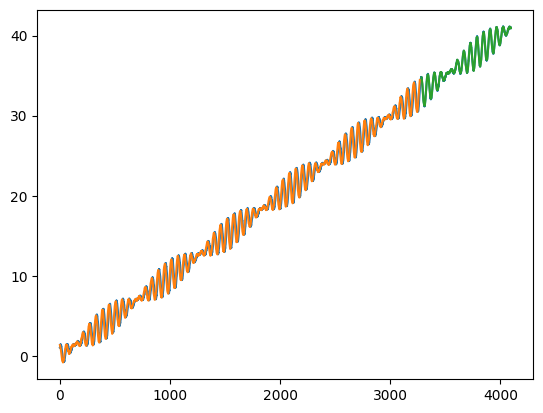

In [162]:
with torch.no_grad():
    
    train_plot = np.ones_like(stationary_data_tr) * np.nan
    y_pred = rnn(x_train)
    y_pred_sq = y_pred.squeeze()
    test_plot = np.ones_like(stationary_data_tr) * np.nan
    test_plot[train_size + seq_length: len(stationary_data_tr)] = rnn(x_test).squeeze()[6:]
   

#denormalization 
stationary_data_tr = stationary_data_tr * (sd_max - sd_min) + sd_min
y_pred_sq = y_pred_sq * (sd_max - sd_min) + sd_min
test_plot = test_plot * (sd_max - sd_min) + sd_min



plt.plot(stationary_data_tr + trend)
plt.plot(y_pred_sq + trend[:train_size - 6])
plt.plot(test_plot + trend)
plt.show()


Теперь обучите на этих же данных LSTM с таким же размером скрытого слоя и визуализируйте результат.

In [179]:

import torch.nn as nn

class Predictor_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1) 

    def forward(self, x):
        out, h = self.lstm(x)
        out = self.fc(h)
        return out



    

In [180]:
input_size = 1
hidden_size = 2
lstm = Predictor_LSTM(input_size, hidden_size)
time_series_train(lstm)

TypeError: ignored

Произведите аналогичные действия с GRU моделью.

In [ ]:
# Your code here



Сравните результаты и скорость работы RNN, LSTM и GRU. 

## Формат результата

Гррафики предсказания RNN, LSTM, GRU.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX08/result_1_task_ex08.png" width="800">

# Задание 2. Генерация фамилий

max 30 баллов

Возьмите следующий набор данных и, используя код из лекции, создайте реккурентную сеть для генерации фамилий. Для ускорения обучения переносите данные и модель на видеокарту. Подумайте, как получить разные фамилии, начинающиеся на одну и ту же букву.


In [ ]:
# Написать даталоадер

import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

set_random_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX08/surnames.txt

In [ ]:
with open("surnames.txt", encoding="utf-8") as s_file:
    surnames_list = [line.strip().lower() for line in s_file.readlines()]

In [ ]:
print(surnames_list)

In [ ]:
# Your code here

## Формат результата

Модель генерирующая фамилии по первой букве.

Пример:

а - Аркова

б - Банова

в - Варенков

г - Гаранков

# Задание 3. Классификация с помощью трансформера

max 30 баллов

Возьмите набор данных эмоциональных окрасок отзывов [emotions dataset](https://huggingface.co/datasets/emotion). В датасете 5 классов. Получите эмбеддинг из трансформера BERT и классифицируйте тексты при помощи логистической регрессии.


In [ ]:
!pip install -q transformers
!pip install -q datasets

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
from datasets import load_dataset
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train = load_dataset("SetFit/emotion", split="train")
train_df = pd.DataFrame({"text": train["text"], "emotion": train["label"]})
train_df.head()

Инициализация токенайзера и модели. Перед тем как отправить текст в модель его следует токенизировать. API токенизатора для BERT смотрите на сайте: https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer

Кроме информации с официального сайта можно воспользоваться ссылкой:

https://towardsdatascience.com/how-to-use-bert-from-the-hugging-face-transformer-library-d373a22b0209


In [ ]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.BertModel,
    ppb.BertTokenizer,
    "bert-base-uncased",
)

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model.to(device)
print(device)

In [ ]:
# Your code here

Посмотрите на выходы модели:

https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel.forward.returns

Среди них есть эмбеддинги в ключах: pooler_output и hidden_state

Попробуйте использовать один из них для классификации.

В данном задании достаточно использовать 5000 фраз (4000 train, 1000 test).

In [ ]:
# Your code here

## Формат результата

Получить значение качества классификации с помощью логистической регрессии (f1 score по каждому классу, хотя бы по одному классу значение > 0.65)